In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers
import math
import os
import glob
import tensorflow_datasets as tfds

In [ ]:
# path = '/content/drive/MyDrive/Denoise data'
# temp = os.path.join(path,'*.npy')
# images = glob.glob(temp)

# data = []
# for i in range(len(images)):
#   for j in range(6):
#     temp2 = np.load(images[i])
#     data.append(tf.tile(np.expand_dims(temp2[:,:,j],axis = 2),[1,1,3]))

# data_f = np.stack(data)
# print(data_f.shape)


Padding the original image

In [ ]:
# def padd(image,size):
#   image = np.array(image)
#   width_f,height_f = [size,size]

#   padding_width = max(0, width_f - image.shape[1])
#   padding_height = max(0,height_f - image.shape[0])

#   pad_left , pad_right = [padding_width // 2 , padding_width // 2]
#   pad_up , pad_down = [padding_height // 2 , padding_height // 2]

#   new_image = np.pad(image,((pad_up,pad_down),(pad_left,pad_right),(0,0)), mode = 'edge')

#   return new_image

# size_f = 512
# data_temp = []
# for i in range(len(data)):

#   data_temp.append(padd(data[i],size_f))

# print(data_temp[0].shape)
# print(len(data_temp))


In [ ]:
# # data = data_temp 3040
# data_temp = data_temp[:3040]
# data_f = []
# for i in range(len(data_temp)):
#   data_f.append(tf.clip_by_value(data_temp[i]/255.0, 0.0, 1.0))


In [ ]:
# size1 = 32*76
# size2 = 32*19

# train_dataset, val_dataset = tf.split(data_f,[size1,size2])
# print(train_dataset.shape)
# print(val_dataset.shape)

In [5]:

def preprocess_image(data):
    # center crop image
    height = tf.shape(data["image"])[0]
    width = tf.shape(data["image"])[1]
    crop_size = tf.minimum(height, width)
    image = tf.image.crop_to_bounding_box(
        data["image"],
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
    image = tf.image.resize(image, size=[image_size, image_size], antialias=True)
    return tf.clip_by_value(image / 255.0, 0.0, 1.0)


def prepare_dataset(split):
    # the validation dataset is shuffled as well, because data order matters
    # for the KID estimation
    return (
        tfds.load(dataset_name, split=split, shuffle_files=True)
        .map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        .cache()
        .repeat(dataset_repetitions)
        .shuffle(10 * batch_size)
        .batch(batch_size, drop_remainder=True)
        .prefetch(buffer_size=tf.data.AUTOTUNE)
    )


# load dataset
train_dataset = prepare_dataset("train[:80%]+validation[:80%]+test[:80%]")
val_dataset = prepare_dataset("train[80%:]+validation[80%:]+test[80%:]")

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteEU5H6A/oxford_flowers102-train.tfrecord*…

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteEU5H6A/oxford_flowers102-test.tfrecord*.…

Generating validation examples...:   0%|          | 0/1020 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/oxford_flowers102/2.1.1.incompleteEU5H6A/oxford_flowers102-validation.tfre…

Dataset oxford_flowers102 downloaded and prepared to /root/tensorflow_datasets/oxford_flowers102/2.1.1. Subsequent calls will reuse this data.


Hyperparameters

In [4]:
# input shape to the model
image_size = 64
# image_w = 512
dataset_name = "oxford_flowers102"
dataset_repetitions = 5

# training variables
epoch = 20
batch_size = 32
ema = 0.999
learning_rate = 1e-3
weight_decay = 1e-4

#UNet++ specification
embeding_dims = 32
max_embed_freq = 1000.0
widths = [32,64,96,128,256,512]

UNet ++

In [6]:
def residual_block(width):
  def apply(x):
    size = x.shape[3]
    if (size == width):
      residual = x
    else:
      residual = layers.Conv2D(width, kernel_size=1)(x)

    x = layers.BatchNormalization(center = False, scale = False)(x)
    x = layers.Conv2D(width,kernel_size = 3, padding = 'same' , activation = keras.activations.swish)(x)
    x = layers.Conv2D(width,kernel_size = 3, padding = 'same' , activation = keras.activations.swish)(x)
    x = layers.Add()([x,residual])
    # print(x.shape)
    return x
  return apply

def decoder_block(width):
  def apply(x):
    x, skips = x
    x = layers.UpSampling2D(size = 2, interpolation = 'bilinear')(x)
    x = layers.Concatenate()([x,skips.pop()])
    x = residual_block(width)(x)
    # print(x.shape)
    return x
  return apply

def encoder_block(width):
  def apply(x):
    x,skips = x
    x = residual_block(width)(x)
    skips.append(x)
    x = layers.AveragePooling2D(pool_size = 2)(x)
    # print(x.shape)
    return x
  return apply

def skip_final(skips):
  skips_true = []
  temp = []
  skips_true.append(skips[0])
  while(True):
    for i in range(len(skips)-1):
      temp.append(layers.Concatenate()([skips[i+1],layers.UpSampling2D(size = 2, interpolation = 'bilinear')(skips[i])]))
      # print(layers.Concatenate()([skips[i+1],layers.UpSampling2D(size = 2, interpolation = 'bilinear')(skips[i])]).shape)

    skips = temp
    skips_true.append(temp[0])
    if(len(temp) == 1):
      break
    temp = []

  return skips_true


def Network(image_size,widths):
  input = keras.Input(shape=(image_size,image_size,3))
  skips = []
  x = layers.Conv2D(widths[0],kernel_size = 3,padding = 'same')(input)

  for width in widths[:-1]:
    x = encoder_block(width)([x,skips])
    # print(x.shape)

  x = residual_block(widths[-1])(x)
  skips.reverse()
  skips = skip_final(skips)
  # for i in range(len(skips)):
    # print(skips[i].shape)
  skips.reverse()

  for width in reversed(widths[:-1]):
    x = decoder_block(width)([x,skips])
    # print(x.shape)

  x = layers.Conv2D(3,kernel_size = 3, kernel_initializer = "zeros",padding = 'same')(x)

  return keras.Model(input,x,name = "UNet_plusplus")



abc = Network(image_size,widths)
abc.summary()












Model: "UNet_plusplus"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 64, 64, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   896         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 64, 64, 32)  64          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 32)   9248        ['batch_normalization

In [7]:
class Auto_encoder(keras.Model):
  def __init__(self,image_size,widths):
    super().__init__()

    self.normalizer = layers.Normalization()
    self.network = Network(image_size,widths)
    self.ema_network = keras.models.clone_model(self.network)


  def compile(self,**kwargs):
    super().compile(**kwargs)

    self.image_loss_tracker  = keras.metrics.Mean(name = "i_loss")

  @property
  def metric(self):
    return [self.image_loss_tracker]

  def train_model(self,image,training):
    if training:
      network = self.network
    else:
      network = self.ema_network

    pred_image = network(image,training = training)
    return pred_image


  def train_step(self,image):
    image = self.normalizer(image, training = True)

    with tf.GradientTape() as tape:
      pred_image = self.train_model(image,training = True)
      image_loss = self.loss(image,pred_image)

    gradients = tape.gradient(image_loss,self.network.trainable_weights)
    self.optimizer.apply_gradients(zip(gradients,self.network.trainable_weights))

    self.image_loss_tracker.update_state(image_loss)

    for weight, ema_weight in zip(self.network.weights, self.ema_network.weights):
      ema_weight.assign(ema*ema_weight + (1-ema)*weight)

    return {m.name: m.result() for m in self.metrics}

  def test_step(self,image):
    image = self.normalizer(image, training = True)

    pred_image = self.train_model(image,training = False)

    image_loss = self.loss(image,pred_image)

    self.image_loss_tracker.update_state(image_loss)

    return {m.name: m.result() for m in self.metrics}



In [8]:
# train_dataset = tf.data.Dataset.from_tensor_slices(train_dataset).batch(batch_size)
# val_dataset = tf.data.Dataset.from_tensor_slices(val_dataset).batch(batch_size)


In [9]:
model = Auto_encoder(image_size,widths = widths)

model.compile(optimizer = keras.optimizers.experimental.AdamW(
                learning_rate = learning_rate, weight_decay = weight_decay

          ),
              loss = keras.losses.mean_absolute_error,
              )

checkpoint_path = "/content/drive/MyDrive/Auto_encoder/"
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path,
    save_weights_only=True,
    monitor="i_loss",
    mode="min",
    save_best_only=True,
)

model.normalizer.adapt(train_dataset)

# model.fit(train_dataset,epochs = epoch, validation_data = val_dataset,
#           callbacks = [checkpoint_callback],
#           )



In [10]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
img = cv2.imread('/content/drive/MyDrive/image02.jpg')


height = tf.shape(img)[0]
width = tf.shape(img)[1]
crop_size = tf.minimum(height, width)
image = tf.image.crop_to_bounding_box(
        img,
        (height - crop_size) // 2,
        (width - crop_size) // 2,
        crop_size,
        crop_size,
    )

    # resize and clip
    # for image downsampling it is important to turn on antialiasing
image = tf.image.resize(image, size=[image_size, image_size], antialias=True)

print(image.shape)




(64, 64, 3)


In [11]:
model.load_weights(checkpoint_path)
img = tf.expand_dims(image,axis = 0)
print(img.shape)
image1 = model.train_model(img,training = False)

(1, 64, 64, 3)


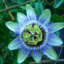

In [12]:
image1 = tf.reshape(image1,(64,64,3))
image1 = np.array(image1)
cv2_imshow(image1)

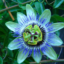

In [13]:
image = np.array(image)
cv2_imshow(image)

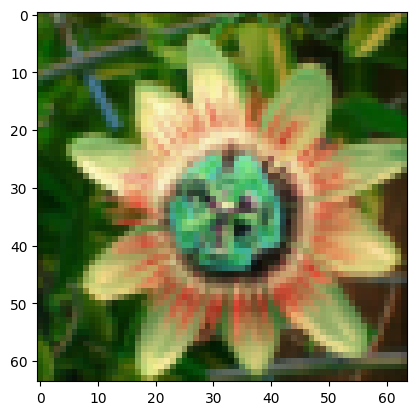

In [20]:
import matplotlib.pyplot as plt
image1 = tf.clip_by_value(image1/255.0,0.0,1.0)
plt.imshow(image1)

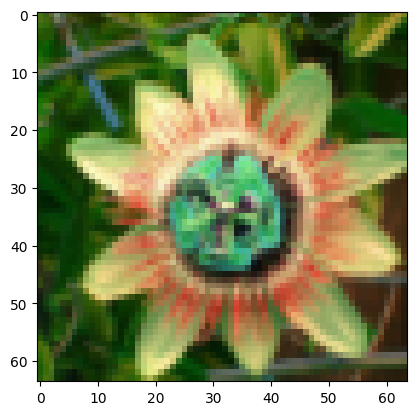

In [21]:
image = tf.clip_by_value(image/255.0,0.0,1.0)
plt.imshow(image)